In [2]:
import numpy as np #librería para cálculos numéricos
import pandas as pd #librería para manipular datos
import matplotlib.pyplot as plt #librería para graficar
import matplotlib.cm as cm #librería para mapas de colores
import networkx as nx #librería para crear y manipular grafos
import csv #librería para leer y escribir archivos CSV

1. GENERACIÓN MATRIZ M

In [3]:
# 1.1 Leer el archivo CSV sin cabecera
df = pd.read_csv('BACI_HS92_Y2010_V202501.csv', sep=',', header=0, dtype={'k': str})
df = df.fillna(0) # Rellenar valores faltantes con 0

incomplete_rows = df[df.isnull().any(axis=1)]
print(f"Número de filas incompletas (con valores faltantes): {len(incomplete_rows)}")

Número de filas incompletas (con valores faltantes): 0


Contenido de BACI_HS92_Y2010_V202501.csv:

Productos en nomenclatura de 6 dígitos del Sistema Armonizado.
Flujos comerciales a nivel de año - exportador - importador - producto.

t, 1ª columna, año

i, 2ª columna, país exportador

j, 3ª columna, país importador

k, 4ª columna, producto

v, 5ª columna, volumen de producto intercambiado (toneladas métricas)

q, 6ª columna, valor monetario de la transacción (Cientos de dólares)

In [4]:
# 1.2. Agrupar los productos, k, para quedarse con los primeros 4 dígitos.
df['k'] = df['k'].apply(lambda x: str(x)[:4])  # Convertir 'k' a string antes de aplicar el slicing

In [5]:
print(df.head(10))

      t  i   j     k       v       q
0  2010  4   8  6106   0.192   0.003
1  2010  4   8  6215   0.845   0.005
2  2010  4   8  6309   0.317   0.017
3  2010  4   8  8519   0.150   0.001
4  2010  4   8  8528   0.188   0.014
5  2010  4   8  8529   0.019   0.001
6  2010  4   8  9504   0.150   0.001
7  2010  4  12  1211  18.709  23.370
8  2010  4  12  8302  25.670   1.395
9  2010  4  12  8517  51.937   0.072


In [6]:
#pip install openpyxl #Instalar openpyxl para manejar archivos Excel

# 1.3. Crear la matriz usando pivot_table para manejar entradas duplicadas
M = df.pivot_table(index='i', columns='k', values='q', aggfunc='sum')

# Reemplazar NaN por 0 en la matriz resultante
M = M.fillna(0)

# Convertir la matriz M a un DataFrame de pandas para facilitar su manipulación
M = pd.DataFrame(M, index=M.index, columns=M.columns)
# Exportar la matriz M a un archivo Excel
# Comparar los valores de matriz_M.xlsx con matriz_M_1.xlsx

# # Leer ambos archivos Excel
# M1 = pd.read_excel('matriz_M.xlsx', index_col=0)
# M2 = pd.read_excel('matriz_M_1.xlsx', index_col=0)

# # Asegurar que los índices y columnas coincidan
# M1, M2 = M1.align(M2, join='outer', axis=0)
# M1, M2 = M1.align(M2, join='outer', axis=1)

# # Calcular diferencias
# diferencias = M1 != M2
# num_diferencias = diferencias.sum().sum()

# print(f"Número total de diferencias: {num_diferencias}")

# # Mostrar las diferencias si existen
# if num_diferencias > 0:
#     print("Diferencias encontradas en las siguientes posiciones (fila, columna):")
#     diff_positions = list(zip(*np.where(diferencias.values)))
#     for row_idx, col_idx in diff_positions:
#         fila = M1.index[row_idx]
#         columna = M1.columns[col_idx]
#         print(f"Fila: {fila}, Columna: {columna}, matriz_M: {M1.iloc[row_idx, col_idx]}, matriz_M_1: {M2.iloc[row_idx, col_idx]}")

Balassa‐type “Revealed Comparative Advantage” (RCA) index

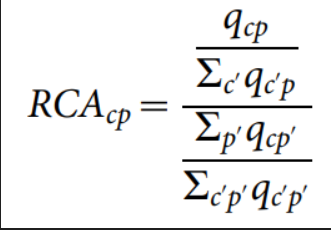

q_cp: quantity (e.g. exports) of product k by country i.

Divided by total quantity of product k across all countries.

Divided by total quantity of all products by country i.

Dividded by total quantity of all products across all countries.

El criterio del filtro no es cantidad exportada, sino el valor que tiene esa cantidad exportada. Si un país regala productos, no afecta en su "economía".

In [7]:
# 1.4. Cálculos para RCA.
# Calcula el RCA_cp para cada elemento de la matriz q y lo sustituye en M.
c, p = M.shape
M_rca = np.zeros((c, p), dtype=float)  # Inicializa la matriz RCA_cp con ceros
suma_total = M.to_numpy().sum()  # Convertir M a un array NumPy para sumar
for i in range(c):
    for j in range(p):
        suma_columna = M.iloc[:, j].sum()
        suma_fila = M.iloc[i, :].sum()
        if suma_columna == 0 or suma_fila == 0:
            M_rca[i, j] = 0  # Evitar división por cero
        else:
            M_rca[i, j] = (M.iloc[i, j] / suma_columna) * (suma_total / suma_fila)

In [8]:
# 1.5. Filtro y creación matriz binaria de M.
for i in range(c):
    for j in range(p):
        M.iloc[i, j] = np.where(M_rca[i, j] >= 1, 1, 0)

In [9]:
# 1.6 Eliminación de nodos con grado 0.
# Convertir M a un DataFrame si es un array de NumPy
if isinstance(M, np.ndarray):
	M = pd.DataFrame(M)

# Eliminar filas y columnas de M que sean todo 0
M = M.loc[~(M == 0).all(axis=1), ~(M == 0).all(axis=0)]

# Verificar si alguna fila o columna de M tiene todos sus valores iguales a 0
filas_todo_cero = (M == 0).all(axis=1).any()
columnas_todo_cero = (M == 0).all(axis=0).any()

if filas_todo_cero:
    print("Índice de filas con todos sus valores en 0:", M.index[(M == 0).all(axis=1)].tolist())
if columnas_todo_cero:
    print("Índice de columnas con todos sus valores en 0:", M.columns[(M == 0).all(axis=0)].tolist())

print(f"¿Alguna fila tiene todos sus valores en 0? {filas_todo_cero}")
print(f"¿Alguna columna tiene todos sus valores en 0? {columnas_todo_cero}")

c,p = M.shape  # Actualizar las dimensiones de M después de eliminar filas y columnas

¿Alguna fila tiene todos sus valores en 0? False
¿Alguna columna tiene todos sus valores en 0? False


In [10]:
# Guardar la matriz M en un archivo Excel
M.to_excel('matriz_M.xlsx')

ALGORITMO

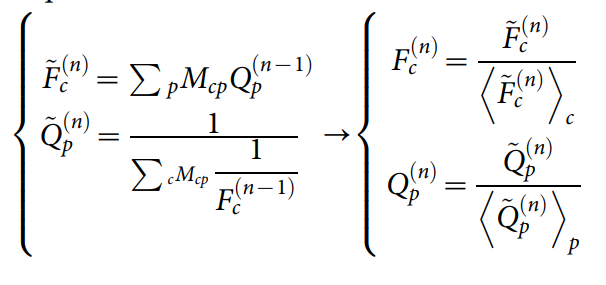

Notación

A^{n}: Vector de la variable A en la iteración n.
Ag^{n}: Vector de la variable no normalizada A en la iteración n. (Variable intemedia de iteración).
B_c^{n}: Componente c de la variable B en la iteración n.

Declaración de variables
F: Vector de la Competitividad normalizada.
Q: Vector de la Complejidad normalizadas.
F_valores: Matriz que guarda los valores de F en cada iteración.
Q_valores: Matriz que guarda los valores de Q en cada iteración.

Consideraciones sobre las Condiciones iniciales:
Para el paso previo de calcular Fg^{n} y Qg^{n}, es necesario haber normalizado F^{n-1} y Q^{n-1}. 
Se toma A^{n} = 0 para el caso de Ag^{n-1} = 0.

Para calcular las variables intermedias Fg^{1} y Qg^{1}, se calculan primero F^{0} y Q^{0}.

In [11]:
#Condiciones iniciales.
Fg = np.ones(c)
Qg = np.ones(p)
# Condiciones iniciales normalizadas.
F = Fg / np.mean(Fg)
Q = Qg / np.mean(Qg)

In [12]:
# Definimos el número de iteraciones.
n = 80

# Generamos la matriz que va a guardar los valores de las iteraciones para poder representar más tarde la convergencia.
F_valores = np.zeros((n, c))
Q_valores = np.zeros((n, p))

for i in range(n):
    # 1) Cálculo de las variables intermedias:
    Fg = np.dot(M, Q) # donde Fg[c] = \sum_p M_{c,p} * Q[p]
    invF = 1.0 / F # donde invF[c] = 1 / F[c]
    invQ = np.dot(M.T, invF) # donde Qg[p] = \sum_c M_{c,p} * (1/F[c])
    Qg = 1.0 / invQ # np.where(invQ != 0, 1.0 / invQ, 0) # donde Qg[p] = 1 / \sum_c ( M_{c,p} / F_c^{(n-1)} )

    # 2) Normalización y actualización de F y Q para la siguiente iteración.
    F = Fg / np.mean(Fg)
    Q = Qg / np.mean(Qg)

    # 3) Guardar los valores de F y Q en cada iteración para su posterior análisis/representación.
    F_valores[i, :] = F
    Q_valores[i, :] = Q

In [ ]:
# # Guardar F_valores en un archivo Excel
# F_valores_df = pd.DataFrame(F_valores)
# F_valores_df.columns = M.index.values  # Usar los valores de la columna 'i' (índice de M)
# F_valores_df.to_excel('F_valores.xlsx', index=False)

# # Guardar Q_valores en un archivo Excel
# Q_valores_df = pd.DataFrame(Q_valores)
# Q_valores_df.columns = M.columns
# Q_valores_df.to_excel('Q_valores.xlsx', index=False)

In [ ]:
# # Imprime las etiquetas de los primeros 10 productos (columnas de M) junto con sus valores de complejidad Q.
# for etiqueta, valor in zip(M.columns[:10], Q[:10]):
#     print(f"{etiqueta}: {valor}")

0101: 0.30686830175829893
0102: 0.17200100508834687
0103: 1.9818973411243932
0104: 0.155618510789086
0105: 1.5535915434427634
0106: 0.03018330641996805
0201: 0.4604130803215534
0202: 0.4447595456603797
0203: 1.5143742231378405
0204: 0.06883531636398219


C:\Users\ferna\AppData\Local\Temp\ipykernel_21516\1513184421.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


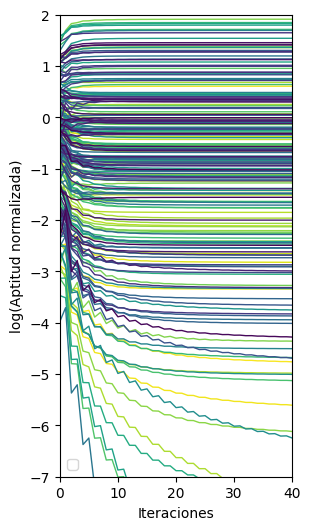

In [15]:
# Representar la evolución de las componentes de F en función de las iteraciones
plt.figure(figsize=(10, 6))  # Figura estrecha y alta

# Generar un colormap con un color distinto por componente
colors = cm.viridis(np.linspace(1, 0, c))

for j in range(c):
    plt.plot(range(n), np.log(F_valores[:, j]), color=colors[j], linewidth=1)

plt.ylabel('log(Aptitud normalizada)')
plt.xlabel('Iteraciones')
#plt.title('Evolución de las Componentes de F en función de las Iteraciones', bbox=dict(facecolor="white", alpha=0.5))
plt.ylim(-7, 2)
plt.xlim(0, 40)
plt.gcf().set_size_inches(3, 6)  # Ancho, Alto en pulgadas
plt.legend()
plt.show()

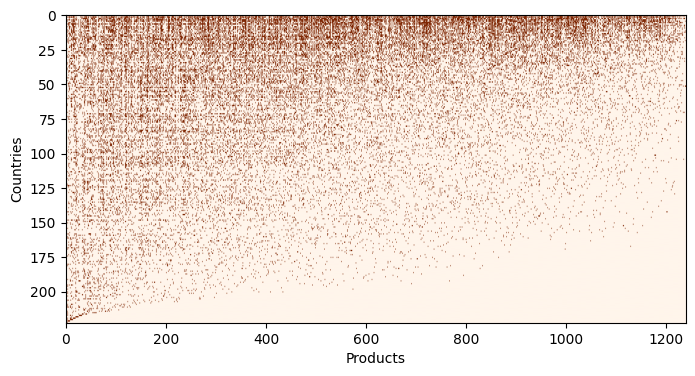

In [16]:
# Representar la matriz M ordenada por Fitness:
plt.figure(figsize=(8, 4))  # Figura ancha

# Ordenar las filas de M según F (de mayor a menor) y las columnas según Q (de mayor a menor)
sorted_row_labels = M.index[np.array(F).argsort()[::-1]]
sorted_col_labels = M.columns[np.array(Q).argsort()[::1]]
M_sorted = M.loc[sorted_row_labels, sorted_col_labels]

plt.imshow(M_sorted, cmap='Oranges', aspect='auto')
plt.ylabel('Countries')
plt.xlabel('Products')
plt.show()

Representación de la red compleja.

In [17]:
# Ordenar los valores de F y Q

# Crear un DataFrame para asociar las filas de M con los valores y etiquetas de F
F_dataframe = pd.DataFrame({'Country': M.index, 'F': F})
# Ordenar el DataFrame por el valor de F en orden descendente
F_ordenado = F_dataframe.sort_values(by='F', ascending=False).reset_index(drop=True)

# Crear un DataFrame para asociar las columnas de M con los valores de Q
Q_dataframe = pd.DataFrame({'Product': M.columns, 'Q': Q})
# Ordenar el DataFrame por el valor de Q en orden descendente
Q_ordenado = Q_dataframe.sort_values(by='Q', ascending=False).reset_index(drop=True)

print("Valores de F ordenados:")
print(F_ordenado)
print("Valores de Q ordenados:")
print(Q_ordenado)

Valores de F ordenados:
     Country             F
0        156  6.772418e+00
1        276  6.343900e+00
2        344  6.228251e+00
3        380  6.035108e+00
4        251  5.554540e+00
..       ...           ...
218      324  4.347958e-04
219       96  2.167992e-04
220      226  4.077128e-05
221      368  2.117235e-06
222      520  1.245495e-13

[223 rows x 2 columns]
Valores de Q ordenados:
     Product             Q
0       0503  2.708859e+01
1       7416  1.153557e+01
2       9108  9.782239e+00
3       7805  9.426964e+00
4       7015  9.130227e+00
...      ...           ...
1234    3817  4.140434e-05
1235    2709  3.884381e-05
1236    0408  2.232521e-12
1237    2510  2.232521e-12
1238    2713  2.232521e-12

[1239 rows x 2 columns]


In [18]:
# Extraer los elementos de M correspondientes a TOPc y TOPp
TOPc = F_ordenado.head(10)['Country'].tolist()  
TOPp = Q_ordenado.head(10)['Product'].tolist()

# Crear un nuevo DataFrame con los elementos de M correspondientes a TOPc y TOPp
M_top = M.loc[TOPc, TOPp]
M_top = M_top.fillna(0)  # Reemplazar NaN por 0 en el DataFrame resultante
print(M_top)

k    0503  7416  9108  7805  7015  8006  7109  2935  9013  5307
i                                                              
156   0.0   0.0   1.0   1.0   1.0   1.0   0.0   1.0   1.0   0.0
276   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
344   0.0   0.0   1.0   1.0   1.0   0.0   0.0   0.0   1.0   0.0
380   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
251   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
490   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0
724   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
392   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   1.0   0.0
826   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0
757   0.0   0.0   1.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0


In [19]:
# Crea un grafo no dirigido
G = nx.Graph()

# Nombres de los 10 primeros países
countries = [str(x) for x in list(M_top.index[:])]
# Nombres de los 10 primeros productos
products = list(M_top.columns[:])

print(countries)
print(products)

['156', '276', '344', '380', '251', '490', '724', '392', '826', '757']
['0503', '7416', '9108', '7805', '7015', '8006', '7109', '2935', '9013', '5307']


In [20]:
# Pasar de códigos a nombres de países.
# Leer el archivo country_codes_V202501 y crear un diccionario para el mapeo
country_codes = {}
with open('country_codes_V202501.csv', mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        country_codes[row[0]] = row[1]
# Reemplazar los códigos por los nombres.
# Sustituir cada elemento de countries por el valor de la segunda columna evitando países vacíos
countries = [country_codes.get(country, country) for country in countries]

print(countries)

['China', 'Germany', 'Hong Kong', 'Italy', 'France', 'Taiwan', 'Spain', 'Japan', 'UK', 'Switzerland']


In [21]:
# DEFINICIÓN DEL GRAFO

# Añadir nodos al grafo
for country in countries:
    G.add_node(country)
for product in products:
    G.add_node(product)

# Asignar nombres de países a sus códigos numéricos correspondientes en M_top
country_code_mapping = {country_codes.get(str(code), str(code)): code for code in M_top.index}

# Comprobar que todos los países están mapeados correctamente
missing_countries = [c for c in countries if c not in country_code_mapping]
if missing_countries:
    print(f"Advertencia: Los siguientes países no tienen código en country_code_mapping: {missing_countries}")

mapped_countries = [country_code_mapping[country] for country in countries if country in country_code_mapping]

# Añadir las aristas al grafo basado en la matriz de adyacencia
for i, country_code in enumerate(mapped_countries):
    for j, product in enumerate(products):
        if M_top.loc[country_code, product] == 1:  # Indexación por etiqueta
            G.add_edge(countries[i], product)  # Usar nombre original del país

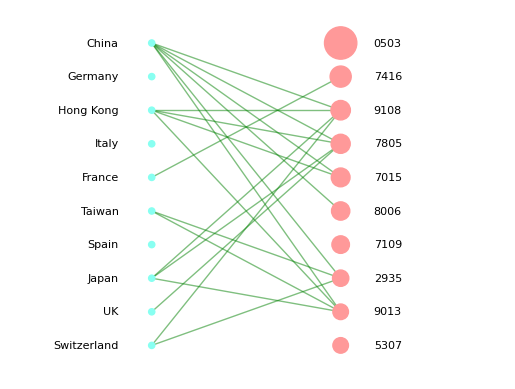

In [22]:
# REPRESENTACIÓN DEL GRAFO

# Colores para los nodos
node_colors = ['#88fff1'] * len(countries) + ['#FF9999'] * len(products)

# Tamaño de los nodos
node_sizes = []
grosor_abs = 20  # Grosor absoluto de los nodos
for node in G.nodes():
    if node in countries:
        # Buscar el valor de F para el país
        valor_F = F_ordenado.loc[F_ordenado['Country'] == node, 'F'].values
        node_sizes.append(valor_F[0] * grosor_abs if len(valor_F) > 0 else grosor_abs)
    elif node in products:
        # Buscar el valor de Q para el producto
        valor_Q = Q_ordenado.loc[Q_ordenado['Product'] == node, 'Q'].values
        node_sizes.append(valor_Q[0] * grosor_abs if len(valor_Q) > 0 else grosor_abs)

# Posicionamiento de nodos
pos = {}
x_offset_countries = 0
x_offset_products = 0.4
y_spacing = 2

# Posicionar países
for idx, country in enumerate(countries):
    pos[country] = (x_offset_countries, -idx * y_spacing)

# Posicionar productos
for idx, product in enumerate(products):
    pos[product] = (x_offset_products, -idx * y_spacing)

# Dibujar nodos y aristas
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='green', alpha=0.5)

# Etiquetas laterales personalizadas
for node, (x, y) in pos.items():
    if node in countries:
        plt.text(x - 0.07, y, node, fontsize=8, ha='right', va='center')
    else:
        plt.text(x + 0.07, y, node, fontsize=8, ha='left', va='center')

# Ajustar límites del gráfico
plt.xlim(-0.3, 0.75) #posición horizontal del borde de la figura
plt.ylim(-len(countries) * y_spacing, 2) #altura de la figura y de los nodos
plt.axis('off')
plt.show()
